Elizarraras Llanos Angel Gustavo

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [70]:
df = pd.read_csv("../engine_metadata.csv")
df

,CUSTOMER_NAME,PLANT_NAME,ENGINE_ID,FILE_ID
0,SPIFFY,SPIRITUAL-POLECAT,ENGINE_1,data_1.csv
1,SPIFFY,SPIRITUAL-POLECAT,ENGINE_2,data_2.csv
2,SPIFFY,SPIRITUAL-POLECAT,ENGINE_3,data_3.csv
3,NONCHALANT,NIFTY-ROOK,ENGINE_1,data_4.csv
4,NONCHALANT,NIFTY-ROOK,ENGINE_2,data_5.csv
...,...,...,...,...
207,SCEPTICAL,GIGANTIC-EARWIG,ENGINE_2,data_209.csv
208,MERCIFUL,PREMIUM-MOTH,ENGINE_1,data_210.csv
209,MERCIFUL,PREMIUM-MOTH,ENGINE_2,data_211.csv
210,MERCIFUL,PREMIUM-MOTH,ENGINE_3,data_212.csv


In [71]:
customer_names = df["CUSTOMER_NAME"].value_counts().index.values
customer_names

array(['BUSY', 'JUDICIOUS', 'DELIGHTFUL', 'GLEAMING', 'DRAMATIC', 'SOFT',
       'FERVENT', 'NONCHALANT', 'IDEALISTIC', 'TANGIBLE', 'SCEPTICAL',
       'TOUGH', 'KIND', 'MERCIFUL', 'SPIFFY'], dtype=object)

# Wrangling the data

In [72]:
def add_working_hours(df):
    speed = df["CMP_SPEED"].values
    hours = [0]
    counter = 0
    for i in range(1, len(speed)):
        if speed[i-1] !=0 and speed[i] != 0:
            counter += 1
        hours.append(counter)
        # appending it to the df
    df["WORKING_HOURS"] = hours
    return df

In [73]:
def process_csv(file):
    df = pd.read_csv(f'../dataset/dataset/{file}', encoding="ISO-8859-1")
    df = add_working_hours(df)
    df = df.dropna()
    df["THRM_EFF"] = df["POWER"] / (47300 * df["FUEL_FLOW"])
    return df.describe()

## Functions for exporting images

In [74]:
def export_eff_vs_power(engine_df, engine_name):
    fig, ax = plt.subplots(figsize=(13,5))
    engine_df.plot(kind="scatter", x="POWER", y="THRM_EFF",
                      ax=ax, title=f"Clients {engine_name}, eff vs power")
    for i, txt in enumerate(engine_df.index):
        ax.annotate(txt, (engine_df["POWER"].values[i], engine_df["THRM_EFF"].values[i]))
    plt.savefig(f"exports/{engine_name}_eff_vs_power")

In [75]:
def export_eff_vs_speed(engine_df, engine_name):
    fig, ax = plt.subplots(figsize=(13,5))
    engine_df.plot(kind="scatter", x="CMP_SPEED", y="THRM_EFF",
                      ax=ax, title=f"Clients {engine_name}, eff vs speed")
    for i, txt in enumerate(engine_df.index):
        ax.annotate(txt, (engine_df["CMP_SPEED"].values[i], engine_df["THRM_EFF"].values[i]))
    plt.savefig(f"exports/{engine_name}_eff_vs_speed")

In [76]:
def export_eff_vs_flow(engine_df, engine_name):
    fig, ax = plt.subplots(figsize=(13,5))
    engine_df.plot(kind="scatter", x="FUEL_FLOW", y="THRM_EFF",
                      ax=ax, title=f"Clients {engine_name}, eff vs flow")
    for i, txt in enumerate(engine_df.index):
        ax.annotate(txt, (engine_df["FUEL_FLOW"].values[i], engine_df["THRM_EFF"].values[i]))
    plt.savefig(f"exports/{engine_name}_eff_vs_flow")

### Starting the wrangling

The main idea of the following code is to solve the question:
- __How do the effience of each type of engine compare between clients?__

For example, each client who has the "ENGINE_1", has a different __mean__ thermal efficiency between all the "ENGINE_1" he posesses, so they have the engines working in different conditions, so maybe (without considering the geography of the zone) based on oher customers working conditions we can recommend the client the power, speed and flow that can maximize the efficiency, and if it is maximized, the cost of running it is minimized.


__Pipeline:__
1. Group the metadata by the type of engine
2. Get the corresponding .csv route for each type of engine and the corresponding client
3. Process each one of the .csv in order to get the mean value of each of the columns [CMP_SPEED, POWER, FUEL_FLOW, CO2]
4. Stack every mean value [CMP_SPEED, POWER, FUEL_FLOW, CO2] of each .csv in a dataframe and get a new mean value, in order to get the mean of all the same type of engine a client has.

    Example: 
    
    `{Client-BUSY: mean-CMP_SPEED=121212, mean-FUEL_FLOW=121212...`
    
      `Client-X: mean-CMP_SPEED=423232, mean-FUEL_FLOW=323233... , ...}`
5. Plot and export

In [77]:
csv_per_engine = {}
grouped = df.groupby("ENGINE_ID")
for name, group in grouped:
    customers_engines =  zip(group["FILE_ID"].values, group["CUSTOMER_NAME"].values)
    describe_data = []
    for csv_file, client_name in customers_engines:
        describe_data.append(process_csv(csv_file))
    csv_per_engine[name] = zip(group["FILE_ID"].values,
                               group["CUSTOMER_NAME"].values, 
                               describe_data)

In [78]:
engines = df["ENGINE_ID"].value_counts().index
engines

Index(['ENGINE_1', 'ENGINE_2', 'ENGINE_3', 'ENGINE_4', 'ENGINE_5', 'ENGINE_6',
       'ENGINE_7', 'ENGINE_8'],
      dtype='object')

/tmp/ipykernel_69421/644890823.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(13,5))


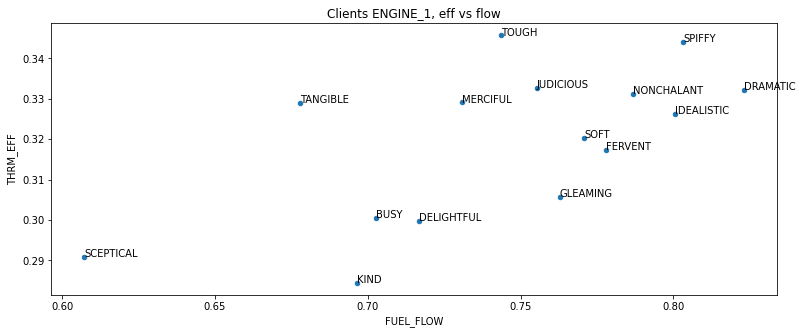

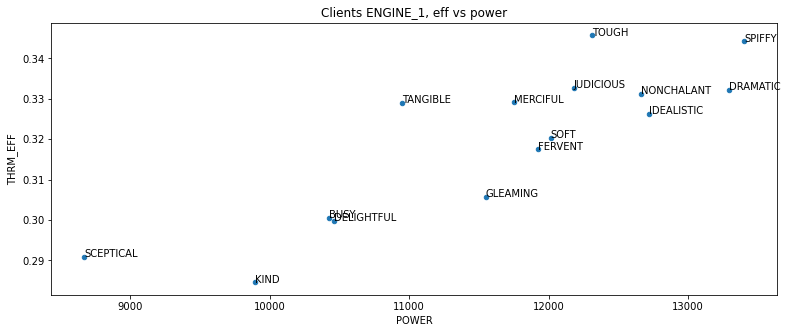

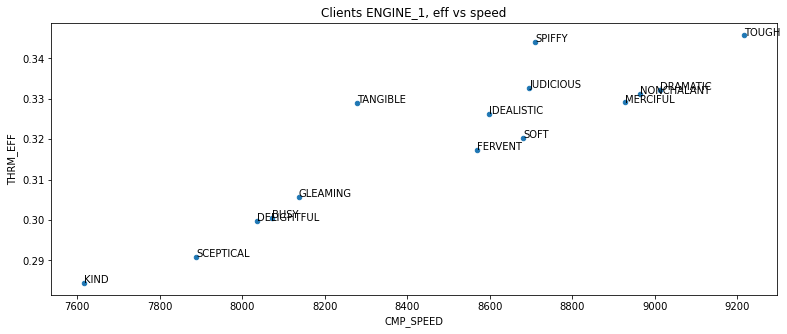

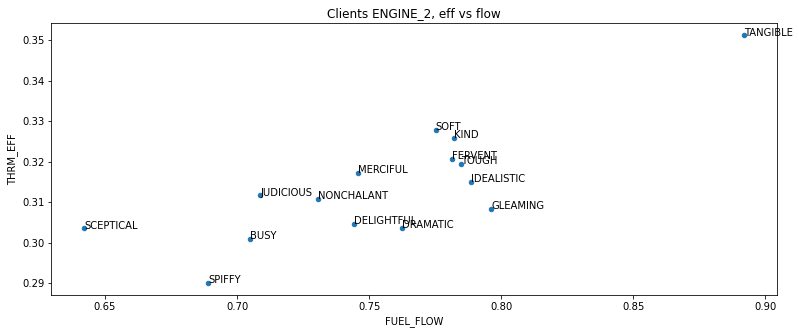

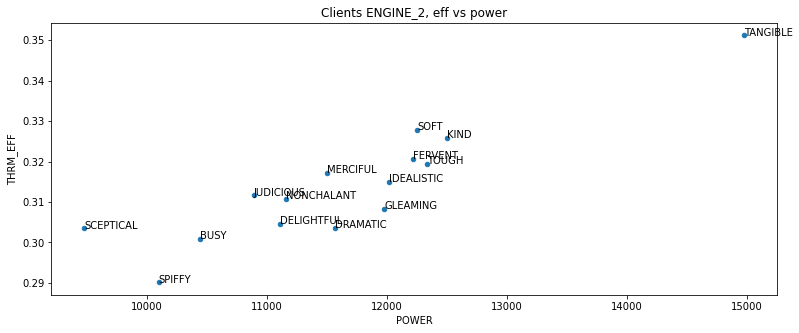

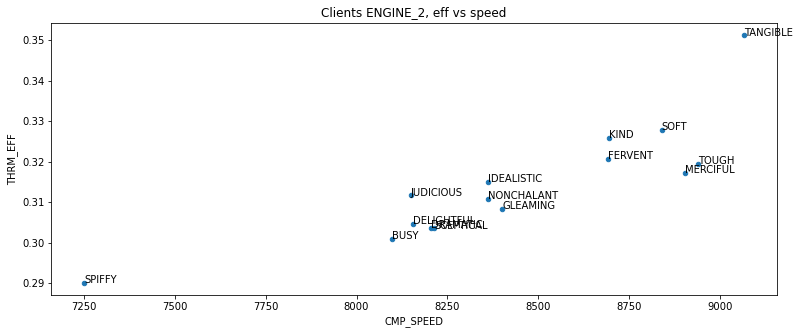

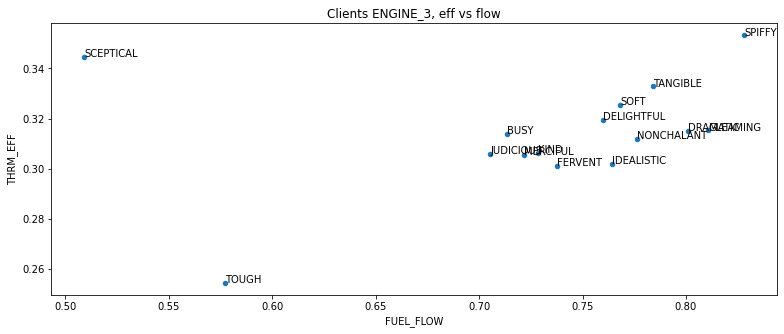

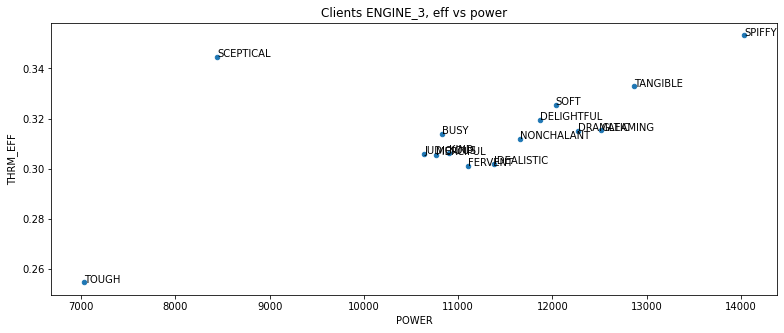

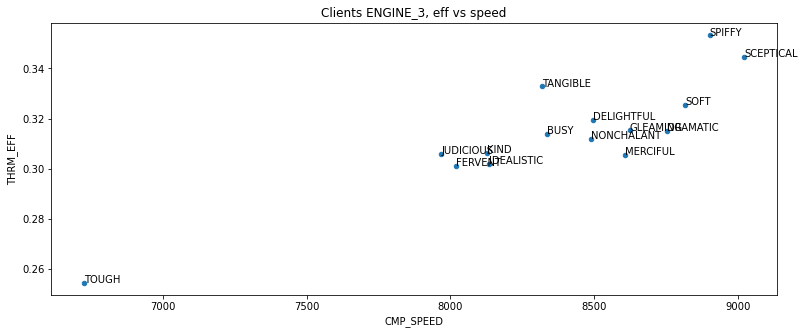

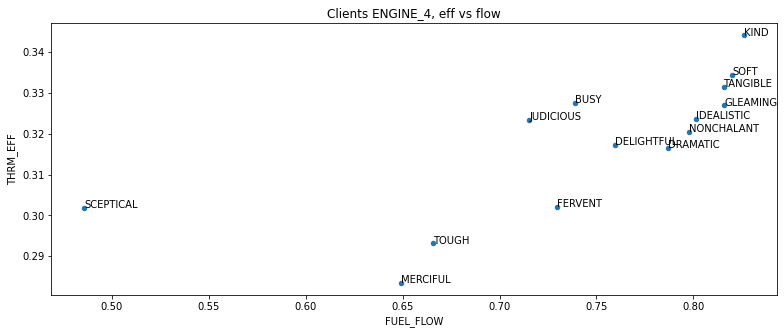

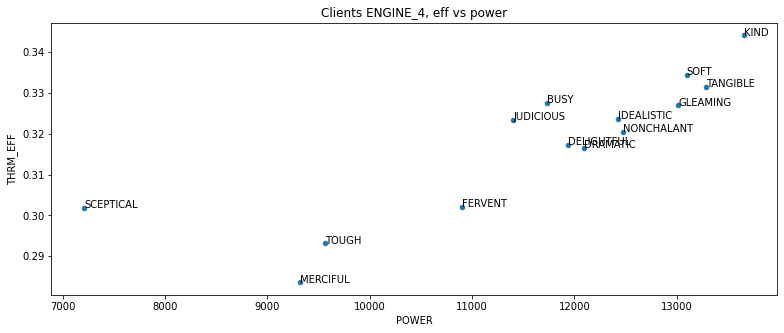

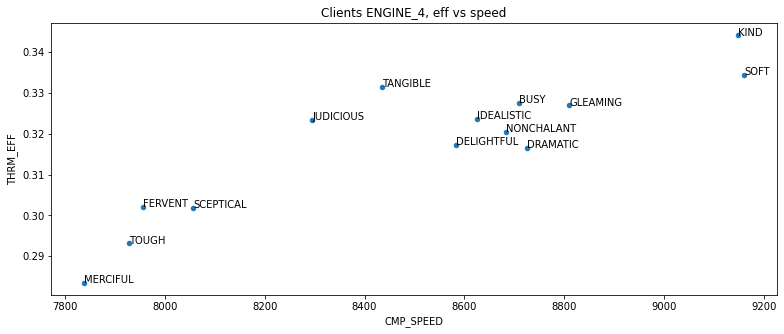

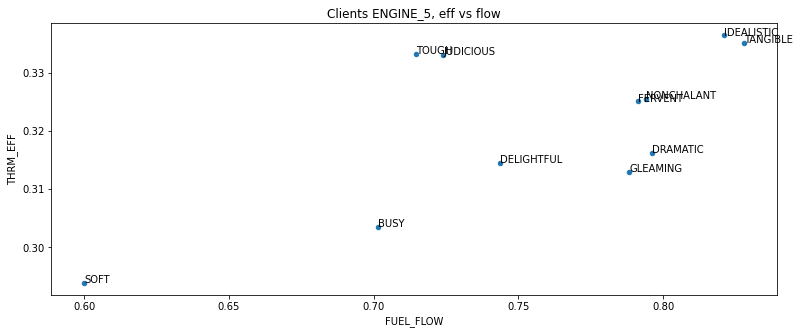

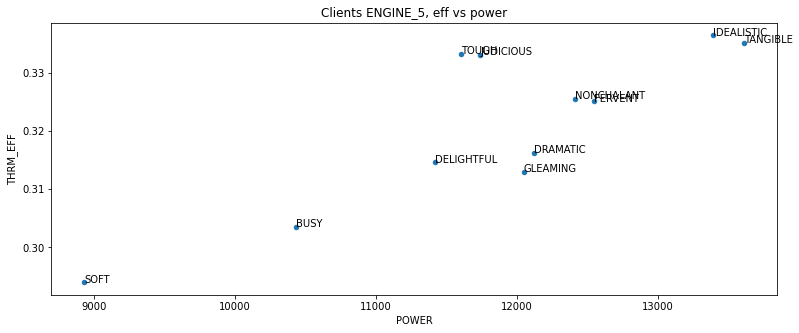

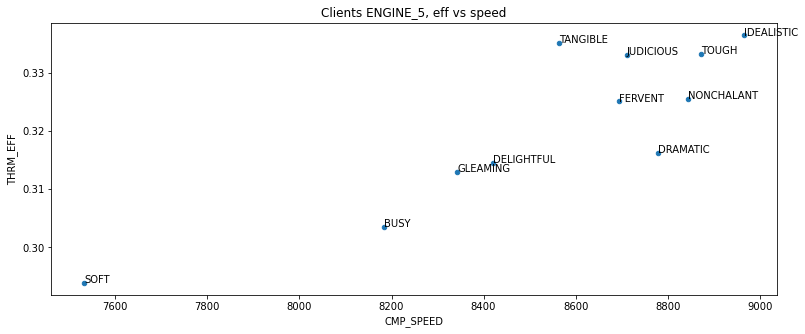

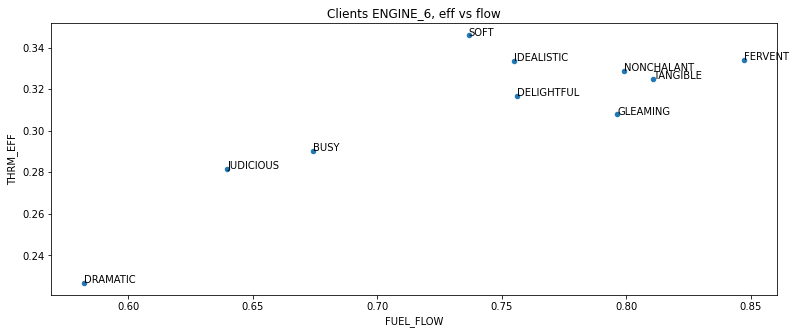

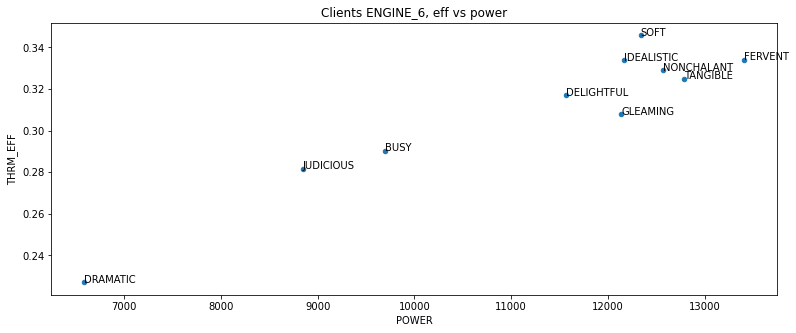

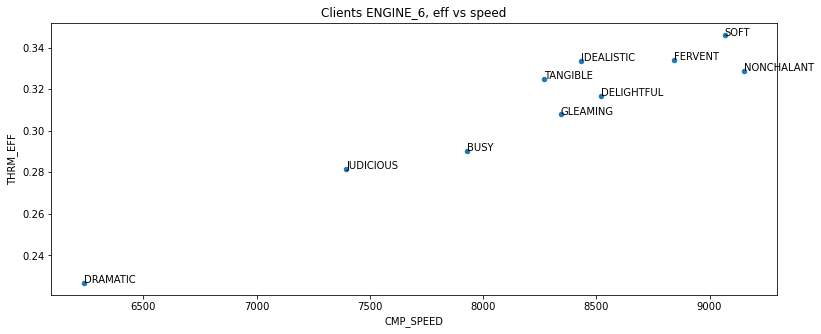

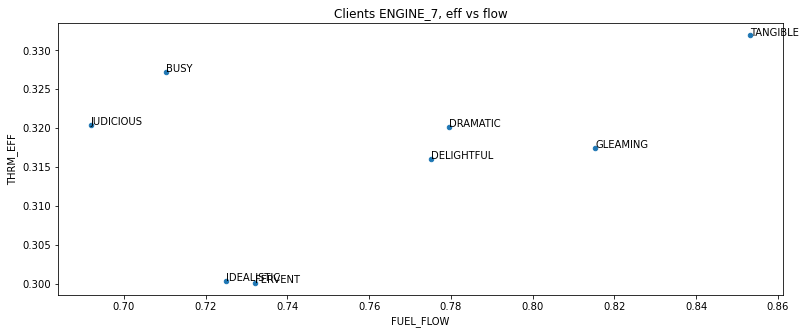

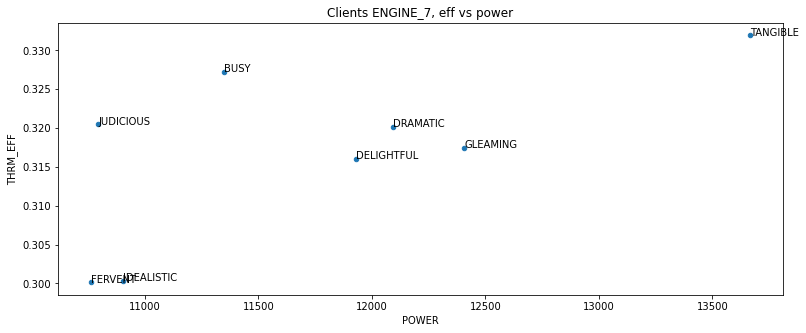

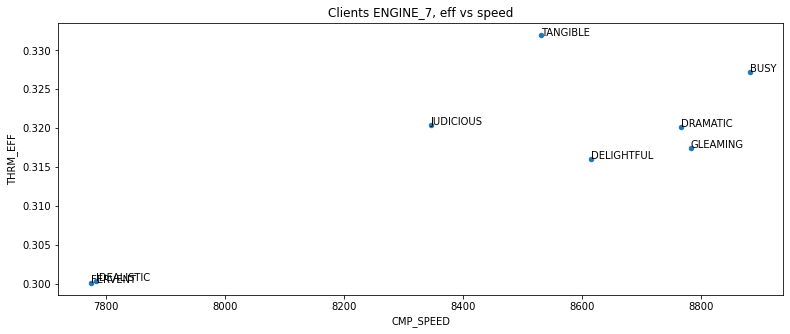

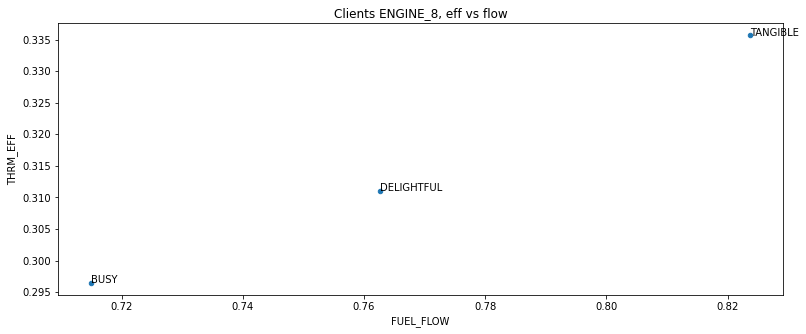

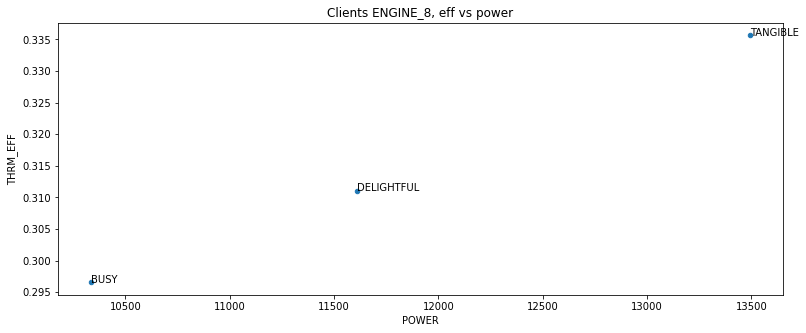

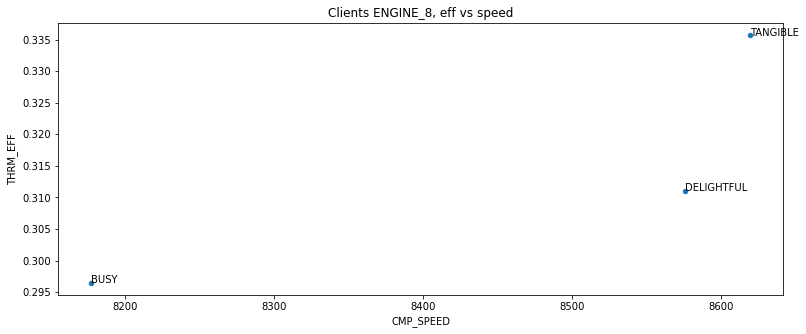

In [79]:
# All engines that each customer have
for engine in engines:
    customer_data = {}
    average_data_clients= {}
    for data_path, client_name, p in csv_per_engine[engine]:
        if client_name not in customer_data.keys():
            customer_data[client_name] = [p.iloc[1]]
        else:
            customer_data[client_name].append(p.iloc[1])
    for name, dfs in customer_data.items():        
        if name not in average_data_clients.keys():
            average_data_clients[name] = pd.concat(dfs, axis=1).T.mean()
    engine_df = pd.DataFrame.from_dict(average_data_clients, orient="index")
    export_eff_vs_flow(engine_df, engine)
    export_eff_vs_power(engine_df, engine)
    export_eff_vs_speed(engine_df, engine)